In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Priors

most priors implemented in ScannerBit draw from the unit interval [0,1]. Here a random deviate $x$ from the unit interval gets transformed into arandom deviate $y$ from the target distribution $D$ via the cumulative distribution function (CDF)

$$y = F^{-1}(x)$$

## flat prior

sampling over the parameter range [a,b] by drawing a random value from the unit interval and then performing the transormation according to the CDF

$$F(y) = \int^y_a P(x) dx= \int^y_a \frac{dx}{b-a} = \frac{y-a}{b-a}$$

with the uniform distribution over [a,b] being

$$P(x) = \frac{1}{b-a}$$

This in turn leads leads to a sampled parameter

$$ y = F^{-1}(x) = (b-a)x + a$$

## double log flat join prior

The sampling distrbution looks like

$$P(x) \propto \begin{cases}
    1/|x| & \text{lower} < x < \text{flat-start} \\
    const & \text{flat-start} \leq x \leq \text{flat-end} \\
    1/x   & \text{flat-end} < x < \text{upper} \\
    \end{cases}
    $$

Therefore the Transformation is given by

$$y = \begin{cases}
    \text{lower} \cdot e^{-x} & \text{lower} < x < \text{flat-start} \\
    \frac{x}{const} + \text{flat-start} & \text{flat-start} \leq x \leq \text{flat-end} \\
    \text{flat-end} \cdot e^x & \text{flat-end} < x < \text{upper} \\
    \end{cases}
    $$

with the different sections obeying 

$$
\text{lower} < \text{flat-start} < 0 < \text{flat-end} < \text{upper}
$$



In [70]:
class Prior():
    def __init__(self, lower: float, upper:float, flat_start: float | None = None, flat_end:float | None = None) -> None:
        if lower > upper:
            raise ValueError("range must be given in the following way: lower < upper")
        if flat_start > 0 or flat_end < 0:
            raise ValueError("flat section must contain x=0! Please check your ranges")

        self.lower = lower
        self.upper = upper
        self.flat_start = flat_start if flat_start is not None else lower + 0.25*(upper - lower)
        self.flat_end = flat_end if flat_end is not None else upper - 0.25*(upper - lower)

    def sample(self, size: int | tuple[int]) -> float | tuple[float]:
        return np.random.uniform(size=size)
    
    def flat(self, size: int | tuple[int] | None = None) -> float | tuple[float]:
        size = size if size is not None else 1
        x = self.sample(size=size)
        print(type(x))
        
        return (self.upper - self.lower) * x + self.lower
    
    def double_log_flat_join(self, size: int | tuple[int] | None = None) -> float | tuple[float]:
        size = size if size is not None else 1
        x = self.sample(size=size)

        Nflat = self.flat_end - self.flat_start
        Nlower = self.flat_start * np.log(np.abs(self.flat_start/self.lower))
        Nupper = self.flat_end * np.log(np.abs(self.upper/self.flat_end))
        C = 1 / (Nflat + Nlower + Nupper)
        P01 = C * Nlower
        P12 = C * Nflat
        P23 = C * Nupper

        def transform(x: float) -> float:
            if x <= P01:
                y = self.lower * np.exp(x/(self.flat_start * C))
            elif x > P01 and x < (P01+P12):
                y = self.flat_start + (x - P01) / C
            elif x > (P01+P12) and x <= (P01+P12+P23):
                y = self.flat_end * np.exp((x - (P01+P12)) / (self.flat_end * C))
            else:
                raise ValueError("Problem transforming value for double log flat join")
            return y
        
        samples = []
        for val in x:
            samples.append(transform(val))

        return samples

        

In [142]:
def hist(prior: Prior, prior_type: str, n_samples: int | None = None, n_bins: int | None = None) -> plt.Figure:
    n_samples = n_samples if n_samples is not None else 1000
    n_bins = n_bins if n_bins is not None else 30

    if prior_type == 'flat':
        samples = prior.flat(size=n_samples)
    elif prior_type == 'double_log_flat_join':
        samples = prior.double_log_flat_join(size=n_samples)
    else:
        raise ValueError(f"{prior_type} is not a valid prior type!")
    
    counts, bins = np.histogram(samples, bins=n_bins)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.hist(bins[:-1], bins=bins, weights=counts, color='crimson', histtype='step', label=f'#samples: {n_samples}')
    ax.set_xlabel('parameter range')
    ax.set_ylabel('counts')
    ax.set_xlim(prior.lower, prior.upper)

    if prior_type == 'flat':
        expected = n_samples * (bins[1] - bins[0]) / (prior.upper - prior.lower)
        ax.hlines(expected, xmin=prior.lower, xmax=prior.upper, colors='indigo', linestyles='--', label="expected avg")

    if prior_type == 'double_log_flat_join':
        Nlower = prior.flat_start * np.log(np.abs(prior.flat_start/prior.lower))
        Nflat = prior.flat_end - prior.flat_start
        Nupper = prior.flat_end * np.log(np.abs(prior.upper/prior.flat_end))
        C = 1 / (Nflat + Nlower + Nupper)
        P12 = C * Nflat

        x_1 = np.linspace(prior.lower, prior.flat_start, 1000)
        x_2 = np.linspace(prior.flat_end, prior.upper, 1000)
        log_exp_1 = -1/x_1 * Nlower*C * n_samples * 5.5
        log_exp_2 = 1/x_2 * n_samples  

        flat_exp = P12 * n_samples * (bins[1] - bins[0]) / (prior.flat_end - prior.flat_start)
        ax.hlines(flat_exp, xmin=prior.flat_start, xmax=prior.flat_end, colors='indigo', linestyles='--', label="expected avg")
        ax.plot(np.linspace(prior.lower, prior.flat_start, 1000), log_exp_1, color='indigo', linestyle='--')
        ax.plot(np.linspace(prior.flat_end, prior.upper, 1000), log_exp_2, color='indigo', linestyle='--')

    ax.legend()
    
    return fig


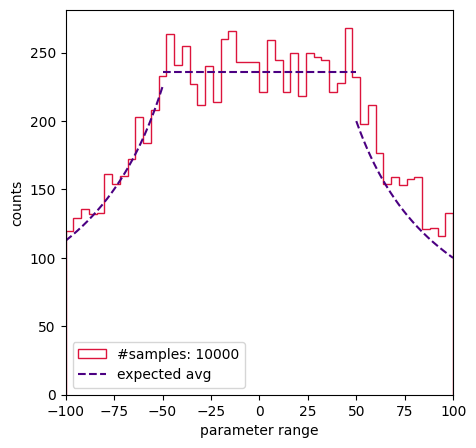

In [143]:
lower = -100
upper = 100
flat_start = -50
flat_end = 50
n_samples = 10000
n_bins = 50

prior = Prior(lower, upper, flat_start, flat_end)
histogram = hist(prior, prior_type='double_log_flat_join', n_samples=n_samples, n_bins=n_bins)
